## Vehicle Detection Project

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

---
**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

[//]: # (Image References)
[image1]: ./examples/car_not_car.png
[image2]: ./examples/HOG_example.jpg
[image3]: ./examples/sliding_windows.jpg
[image4]: ./examples/sliding_window.jpg
[image5]: ./examples/img50.jpg
[image6]: ./examples/example_output.jpg
[video1]: ./project_video.mp4

## [Rubric](https://review.udacity.com/#!/rubrics/513/view) Points

### Here I will consider the rubric points individually and describe how I addressed each point in my implementation.  

---

### Writeup / README

#### 1. Provide a Writeup / README that includes all the rubric points and how you addressed each one.

This is it!

### Histogram of Oriented Gradients (HOG)

#### 1. Explain how (and identify where in your code) you extracted HOG features from the training images.

I started by reading in all the `vehicle` and `non-vehicle` images (do note that I converted them to JPEG beforehand -- the original set is in PNG format):

In [1]:
import glob


# Read the dataset and put it into appropriate lists:
# NOTE: I converted the dataset (originally in PNG) to JPEGs,
# for consistency with the testing images from the video.
cars = glob.glob('./image_set/vehicles/*/*.jpg')
notcars = glob.glob('./image_set/non-vehicles/*/*.jpg')
print('Read {} cars and {} non-cars images total.'.format(len(cars), len(notcars)))

Read 8792 cars and 8968 non-cars images total.


Here is an example of one of each of the `vehicle` and `non-vehicle` classes:

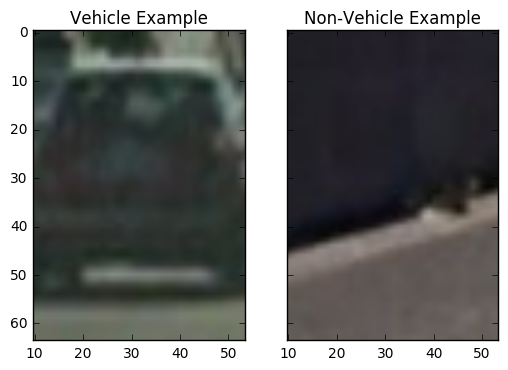

In [130]:
from random import randint
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.imshow(mpimg.imread(cars[randint(0, len(cars))]))
ax1.set_title('Vehicle Example')
ax2.imshow(mpimg.imread(notcars[ randint(0, len(notcars)) ]))
ax2.set_title('Non-Vehicle Example')
plt.show()

Then I setup the relevant functions to extract HOG features, while also converting images to another color space (I tried training the SVM on the classroom and found HSV and HLS to work best, having better validation accuracy) and binning color features:

In [3]:
import numpy as np
import cv2
from skimage.feature import hog

# Define a function to compute binned color features
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:, :, 0], size).ravel()
    color2 = cv2.resize(img[:, :, 1], size).ravel()
    color3 = cv2.resize(img[:, :, 2], size).ravel()
    return np.hstack((color1, color2, color3))
    # Lesson implementation:
    # Use cv2.resize().ravel() to create the feature vector
    # features = cv2.resize(img, size).ravel()
    # Return the feature vector
    # return features


# Define a function to compute color histogram features
# NEED TO CHANGE bins_range if reading .png files with mpimg!
# Live Q&A implementation gets rid of bins_range altogether:
def color_hist(img, nbins=32):  # , bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:, :, 0], bins=nbins)  # , range=bins_range)
    channel2_hist = np.histogram(img[:, :, 1], bins=nbins)  # , range=bins_range)
    channel3_hist = np.histogram(img[:, :, 2], bins=nbins)  # , range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block,
                     vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient,
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  transform_sqrt=True,
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:
        features = hog(img, orientations=orient,
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       transform_sqrt=True,
                       visualise=vis, feature_vector=feature_vec)
        return features


# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                     hist_bins=32, orient=9,
                     pix_per_cell=8, cell_per_block=2, hog_channel=0,
                     spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else:
            feature_image = np.copy(image)

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
            # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:, :, channel],
                                                         orient, pix_per_cell, cell_per_block,
                                                         vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)
            else:
                hog_features = get_hog_features(feature_image[:, :, hog_channel], orient,
                                                pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features
    
    
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images.
# Also, it adds an additional parameter, 'hog_vis', which returns the
# visualization of the hog features.
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9,
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True, hog_vis=False):
    # 1) Define an empty list to receive features
    img_features = []
    # 2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else:
        feature_image = np.copy(img)
    # 3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # 4) Append features to list
        img_features.append(spatial_features)
    # 5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        # 6) Append features to list
        img_features.append(hist_features)
    # 7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_vis == True:
            visualizations = []
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                if hog_vis == True:
                    hog_feat, vis = get_hog_features(feature_image[:, :, channel],
                                                     orient, pix_per_cell, cell_per_block,
                                                     vis=True, feature_vec=True)
                    hog_features.extend(hog_feat)
                    visualizations.extend(vis)
                else:
                    hog_features.extend(get_hog_features(feature_image[:, :, channel],
                                                         orient, pix_per_cell, cell_per_block,
                                                         vis=False, feature_vec=True))
        else:
            if hog_vis == True:
                hog_features, vis = get_hog_features(feature_image[:, :, hog_channel], orient,
                                                     pix_per_cell, cell_per_block, vis=True, feature_vec=True)
                visualizations.extend(vis)
            else:
                hog_features = get_hog_features(feature_image[:, :, hog_channel], orient,
                                                pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # 8) Append features to list
        img_features.append(hog_features)

    # 9) Return concatenated array of features
    if hog_vis == True:
        return np.concatenate(img_features), visualizations
    else:
        return np.concatenate(img_features)

In [79]:
# While testing in the classroom, I found each color space to compare (roughly) 
# in accuracy as follows: HSV > HLS > RGB = LUV = YUV = YCrCb
# However, when used in the pipeline, I found that using all the channels and a YCbCr color space was best.
color_space = 'YCrCb'  # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 8  # HOG orientations
pix_per_cell = 8  # HOG pixels per cell
cell_per_block = 2  # HOG cells per block
hog_channel = 'ALL'  # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32)  # Spatial binning dimensions
hist_bins = 32  # Number of histogram bins
spatial_feat = True  # Spatial features on or off
hist_feat = True  # Histogram features on or off
hog_feat = True  # HOG features on or off

print('Extracting features... this might take a while.')

car_features = extract_features(cars, color_space=color_space,
                                spatial_size=spatial_size, hist_bins=hist_bins,
                                orient=orient, pix_per_cell=pix_per_cell,
                                cell_per_block=cell_per_block,
                                hog_channel=hog_channel, spatial_feat=spatial_feat,
                                hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space,
                                   spatial_size=spatial_size, hist_bins=hist_bins,
                                   orient=orient, pix_per_cell=pix_per_cell,
                                   cell_per_block=cell_per_block,
                                   hog_channel=hog_channel, spatial_feat=spatial_feat,
                                   hist_feat=hist_feat, hog_feat=hog_feat)

print('Features extracted.')

Extracting features... this might take a while.
Features extracted.


I then explored different color spaces and different `skimage.hog()` parameters (`orientations`, `pixels_per_cell`, and `cells_per_block`).  I grabbed random images from each of the two classes and displayed them to get a feel for what the `skimage.hog()` output looks like.

Here is an example using the `YCrCb` color space and HOG parameters of `orientations=8`, `pixels_per_cell=(8, 8)` and `cells_per_block=(2, 2)`:

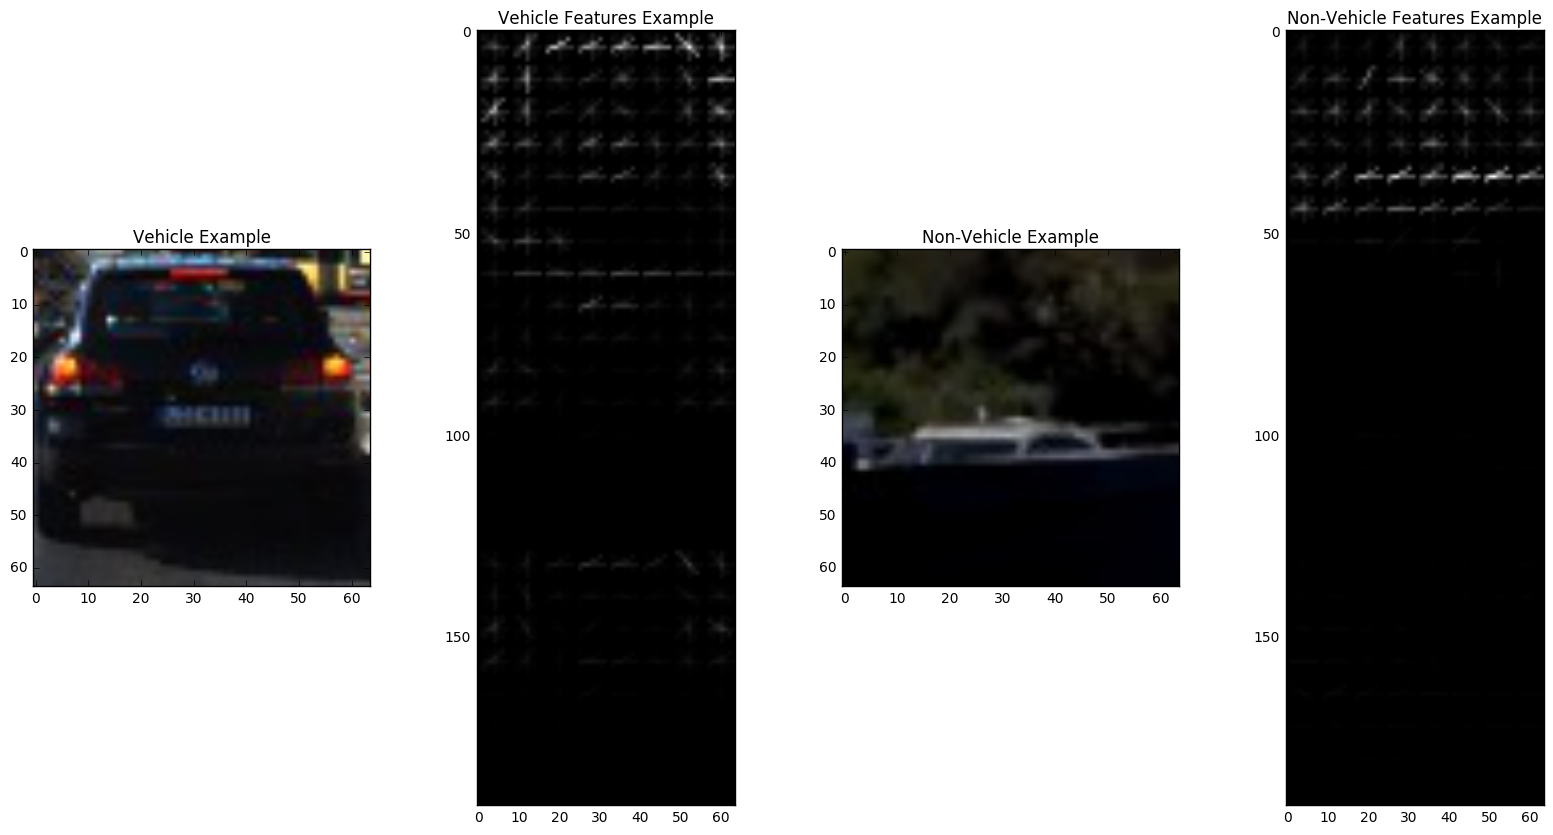

In [80]:
# Get the features for one random 'vehicle' and one 'not-vehicle' image each:
car_example_img = mpimg.imread(cars[randint(0, len(cars)) ])
notcar_example_img = mpimg.imread(notcars[ randint(0, len(notcars)) ])

_, car_features_vis = single_img_features(car_example_img, color_space=color_space,
                                          spatial_size=spatial_size, hist_bins=hist_bins,
                                          orient=orient, pix_per_cell=pix_per_cell,
                                          cell_per_block=cell_per_block,
                                          hog_channel=hog_channel, spatial_feat=spatial_feat,
                                          hist_feat=hist_feat, hog_feat=hog_feat, hog_vis=True)
_, notcar_features_vis = single_img_features(notcar_example_img, color_space=color_space,
                                             spatial_size=spatial_size, hist_bins=hist_bins,
                                             orient=orient, pix_per_cell=pix_per_cell,
                                             cell_per_block=cell_per_block,
                                             hog_channel=hog_channel, spatial_feat=spatial_feat,
                                             hist_feat=hist_feat, hog_feat=hog_feat, hog_vis=True) 
plt.figure(figsize=(20,10))
plt.subplot(141)
plt.imshow(car_example_img)
plt.title('Vehicle Example')
plt.subplot(142)
plt.imshow(car_features_vis, cmap='gray')
plt.title('Vehicle Features Example')
plt.subplot(143)
plt.imshow(notcar_example_img)
plt.title('Non-Vehicle Example')
plt.subplot(144)
plt.imshow(notcar_features_vis, cmap='gray')
plt.title('Non-Vehicle Features Example')
plt.show()

#### 2. Explain how you settled on your final choice of HOG parameters.

I started by trying different combination of color spaces in the lessons, and found, as mentioned before, that the HSV color space was one of the best, along with HLS and even RGB. As for the other parameters, I left them as provided by the lessons at first.

Surprisingly though, the Live Q&A session used YCrCb as the color space, which in my testing was the worst performer of all the color spaces I tried; however, when generating the test video below, I found that it didn't perform badly at all.

#### 3. Describe how (and identify where in your code) you trained a classifier using your selected HOG features (and color features if you used them).

I normalized the features using a StandardScaler, split the data in validation and testing sets as in the previous projects (putting aside 20% of the samples as the testing data), and trained a linear SVM in the cell below, using a feature vector length of 7872, with default parameters, with which I achieved a test accuracy of 97.44%. Trying to improve further, I managed to get a test accuracy of 99.3% using three HOG channels instead of one, however, that slowed the pipeline considerably. Even so, with only one HOG channel and feature extraction, the speed at which the pipeline runs doesn't seem to be adequate for real-time detection, so other methods will have to be tested. 

In [81]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
import time

X = np.vstack((car_features, notcar_features)).astype(np.float64)
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

print('Labeling the feature set...')
# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
print('Feature set labeled.')

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:', orient, 'orientations', pix_per_cell,
      'pixels per cell and', cell_per_block, 'cells per block, with features extracted using',
      color_space, 'color space')
print('Feature vector length:', len(X_train[0]))

print('Starting to train the SVC...')
# Use a linear SVC
svc = LinearSVC()
# Check the training time for the SVC
t = time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2 - t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

Labeling the feature set...
Feature set labeled.
Using: 8 orientations 8 pixels per cell and 2 cells per block, with features extracted using YCrCb color space
Feature vector length: 7872
Starting to train the SVC...
3.17 Seconds to train SVC...
Test Accuracy of SVC =  0.993


### Sliding Window Search

#### 1. Describe how (and identify where in your code) you implemented a sliding window search.  How did you decide what scales to search and how much to overlap windows?

Originally, I took the sliding window implementation from the lessons and used it in the cell below. I restricted my search between Y=(350,670) which corresponded roughly to points just above the horizon and the car hood. I also decided on 3 scales by manually drawing bounding boxes on different car distances corresponding roughly to far, mid-distant and near. As per the overlap, I kept the default one of 0.5 as-is. However, since the implementation is really slow, I decided to extract HOG features from the entire image, as detailed in Sliding Window Search point 2, below.

---

In [82]:
# Define a function that takes an image,
# start and stop positions in both x and y,
# window size (x and y dimensions),
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None],
                 xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0] * (1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1] * (1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan / nx_pix_per_step) - 1
    ny_windows = np.int(yspan / ny_pix_per_step) - 1
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs * nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys * ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]

            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

#### 2. Show some examples of test images to demonstrate how your pipeline is working.  What did you do to try to minimize false positives and reliably detect cars?

Reading about the project on Slack from fellow classmates, using the idea about heatmaps from the lesson, and finally taking the idea from the project's live Q&A to extract HOG features for the whole image and then subsampling the resulting array to search for cars, I did the latter and searched on three scales using YCrCb, three-channel HOG features plus spatially binned color and histograms of color in the feature vector. To reduce false positives, I averaged the heatmap in 5 frames using a deque of max length = 5. In the second cell below, you can see examples of the output, using the provided testing images:

---

In [83]:
# Define a function you will pass an image
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB',
                   spatial_size=(32, 32), hist_bins=32,
                   hist_range=(0, 256), orient=9,
                   pix_per_cell=8, cell_per_block=2,
                   hog_channel=0, spatial_feat=True,
                   hist_feat=True, hog_feat=True):
    # 1) Create an empty list to receive positive detection windows
    on_windows = []
    # 2) Iterate over all windows in the list
    for window in windows:
        # 3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        # 4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space,
                                       spatial_size=spatial_size, hist_bins=hist_bins,
                                       orient=orient, pix_per_cell=pix_per_cell,
                                       cell_per_block=cell_per_block,
                                       hog_channel=hog_channel, spatial_feat=spatial_feat,
                                       hist_feat=hist_feat, hog_feat=hog_feat)
        # 5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        # 6) Predict using your classifier
        prediction = clf.predict(test_features)
        # 7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    # 8) Return windows for positive detections
    return on_windows


# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    # Return updated heatmap
    return heatmap



def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap


def draw_labeled_bboxes(img, labels, color=(0, 0, 255), thick=6):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], color, thick)
    # Return the image
    return img


def convert_color(img, conversion='RGB2HSV'):
    if conversion == 'RGB2HLS':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    if conversion == 'RGB2HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    if conversion == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conversion == 'RGB2YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    if conversion == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conversion == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conversion == 'BGR2YLUV':
        return cv2.cvtColor(img, cv2.COLOR_BGR2LUV)


def find_cars(img, scale=1.5, conv='RGB2HSV', y_start_stop=[None, None]):
    """
    Find cars function from the Live Q&A session.
    """
    draw_img = np.copy(img)
    heatmap = np.zeros_like(img[:, :, 0])
    # img = img.astype(np.float32)/255  # Only done if image is a JPG and extracted features were from PNGs.  
    
    ystart = y_start_stop[0]
    ystop = y_start_stop[1]

    img_tosearch = img[ystart:ystop, :, :]
    if conv is None:
        ctrans_tosearch = np.copy(img_tosearch)
    else:
        ctrans_tosearch = convert_color(img_tosearch, conversion=conv)    

    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

    ch1 = ctrans_tosearch[:, :, 0] 
    ch2 = ctrans_tosearch[:, :, 1]
    ch3 = ctrans_tosearch[:, :, 2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - 1
    nfeat_per_block = orient * cell_per_block**2
    window = 64  # size?
    nblocks_per_window = (window // pix_per_cell) - 1
    cells_per_step = 2  # instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step

    # Compute individual channel HOG features for the entire image:
    # TODO:
    # if hog_channel == 'ALL':
    #     hog_features = []
    #     for channel in range(ctrans_tosearch.shape[2]):
    #         hog_feat = get_hog_features(ctrans_tosearch[:, :, channel], orient, pix_per_cell,
    #                                     cell_per_block, feature_vec=False)
    #         hog_features.extend(hog_feat)
    # else:
    #     hog_features = get_hog_features(ctrans_tosearch[:, :, hog_channel], orient, pix_per_cell,
    #                                     cell_per_block, feature_vec=False)
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

    img_boxes = []
    test_img_boxes = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64, 64))

            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            feature_stack = np.hstack((spatial_features, hist_features, hog_features))
            test_features = X_scaler.transform(feature_stack.reshape(1, -1))
            test_prediction = svc.predict(test_features)

            # Test that boxes are generated correctly:
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                # cv2.rectangle(draw_img, (xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart), (255,0,0), 6)
                img_boxes.append(((xbox_left, ytop_draw+ystart), (xbox_left+win_draw, ytop_draw+win_draw+ystart)))
                heatmap[ytop_draw+ystart:ytop_draw+win_draw+ystart, xbox_left:xbox_left+win_draw] += 1
    return img_boxes, heatmap

2.35 seconds to predict a single image.
2.3 seconds to predict a single image.
2.3 seconds to predict a single image.
2.35 seconds to predict a single image.
2.26 seconds to predict a single image.
2.28 seconds to predict a single image.


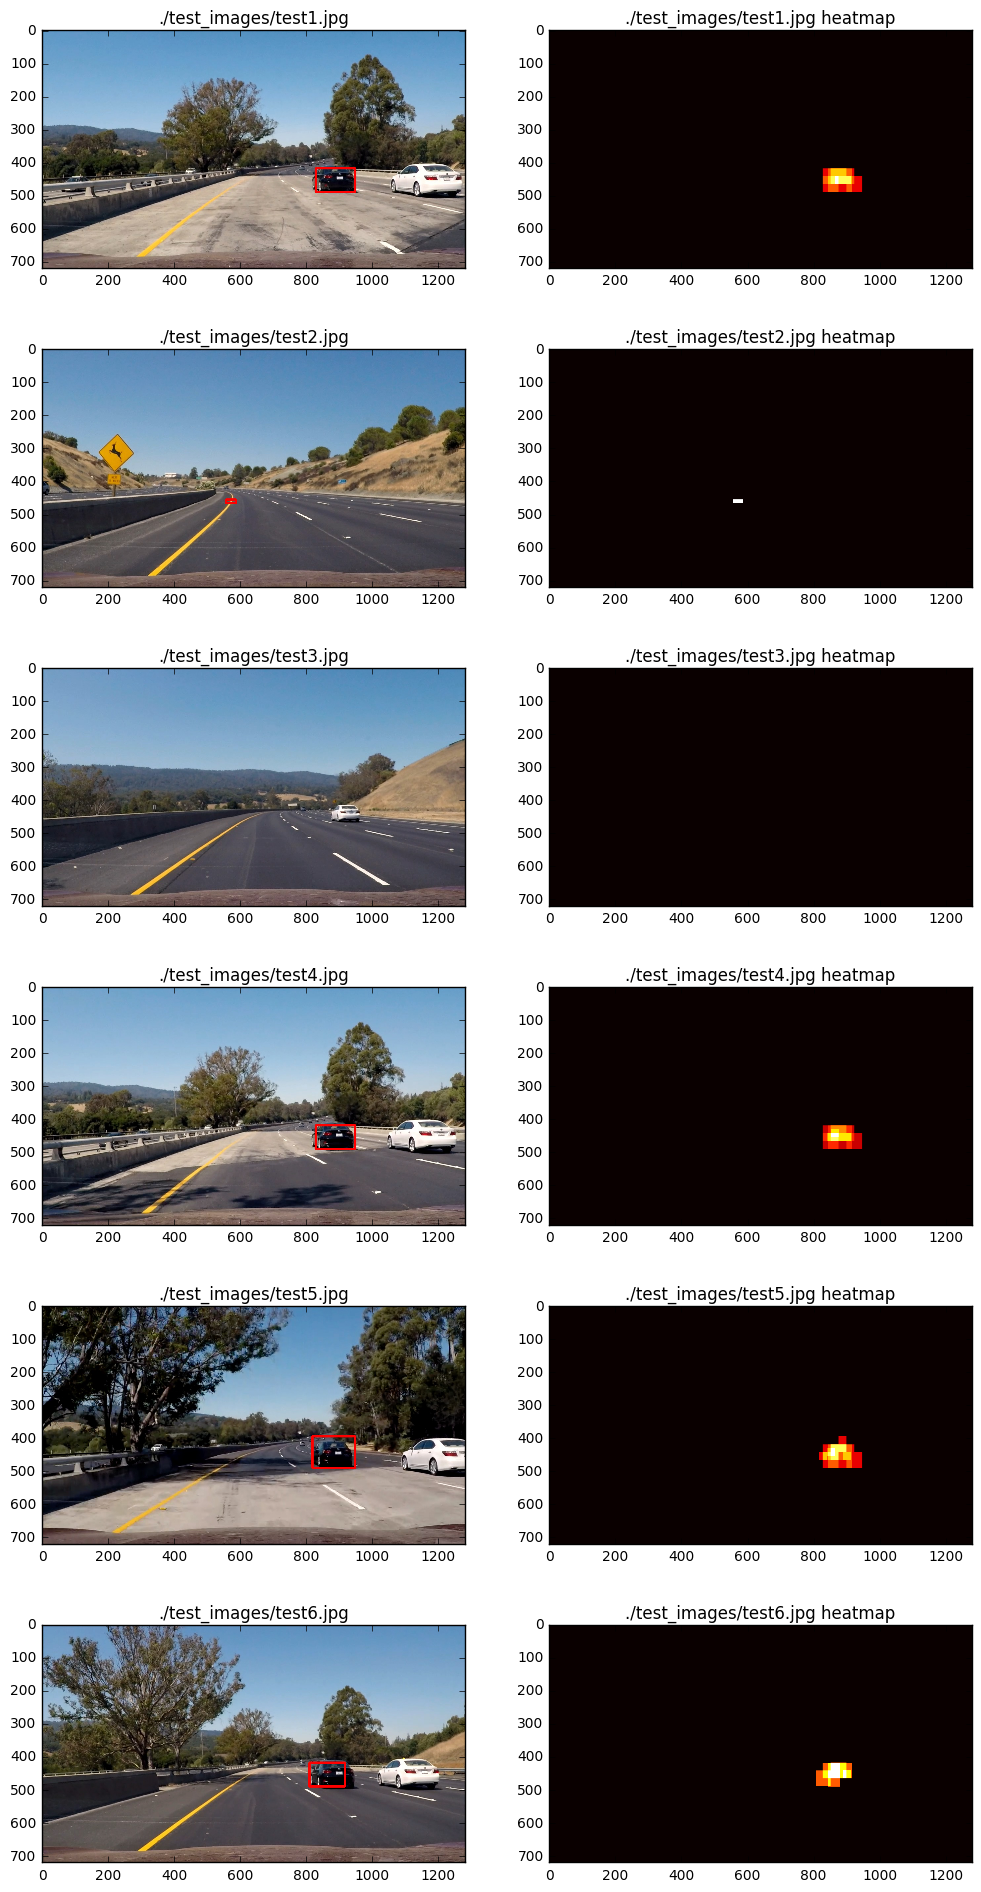

In [136]:
from scipy.ndimage.measurements import label

def visualize(fig, rows, cols, imgs, titles):
    """Helper function for plotting multiple images."""
    for i, img in enumerate(imgs):
        plt.subplot(rows, cols, i+1)
        plt.title(i+1)
        img_dims = len(img.shape)
        if img_dims < 3:
            plt.imshow(img, cmap='hot')
            plt.title(titles[i])
        else:
            plt.imshow(img)
            plt.title(titles[i])

test_images = sorted(glob.glob('./test_images/*.jpg'))
img_paths = test_images
test_images_drawn = []
img_labels = []

for img_src in test_images:
    # Check the prediction time for a single sample
    t = time.time()
    draw_img_test = mpimg.imread(img_src)
    heatmap = np.zeros_like(draw_img_test[:,:,0]).astype(np.float)

    # To (at least try to) speed up processing, I limit the boundaries of each sliding window
    # by their size according to where the window is vertically, starting from the top:    
    windows = slide_window(draw_img_test, x_start_stop=[360,  920], y_start_stop=[370,470],
                           xy_window=(24,24), xy_overlap=(0.5, 0.5))
    windows += slide_window(draw_img_test, x_start_stop=[250, 1030], y_start_stop=[395,545],
                            xy_window=(48,48), xy_overlap=(0.5, 0.5))
    windows += slide_window(draw_img_test, x_start_stop=[195, 1085], y_start_stop=[420,595],
                            xy_window=(72,72), xy_overlap=(0.5, 0.5))
    windows += slide_window(draw_img_test, x_start_stop=[140, 1140], y_start_stop=[445,645],
                            xy_window=(96,96), xy_overlap=(0.5, 0.5))

    hot_windows = search_windows(draw_img_test, windows, svc, X_scaler, color_space=color_space,
                                 spatial_size=spatial_size, hist_bins=hist_bins,
                                 orient=orient, pix_per_cell=pix_per_cell,
                                 cell_per_block=cell_per_block,
                                 hog_channel=hog_channel, spatial_feat=spatial_feat,
                                 hist_feat=hist_feat, hog_feat=hog_feat)
    
    # Process the heatmap:
    heatmap = add_heat(heatmap, hot_windows)
    heatmap = apply_threshold(heatmap, 1)
    heatmap = np.clip(heatmap, 0, 255)
    labels_test = label(heatmap)
    draw_img_test = draw_labeled_bboxes(draw_img_test, labels_test, color=(255, 0, 0), thick=6)
    test_images_drawn.append(draw_img_test)
    img_labels.append(img_src)
    test_images_drawn.append(heatmap)
    img_labels.append(img_src + ' heatmap')

    t2 = time.time()
    print(round(t2 - t, 2), 'seconds to predict a single image.')

# Now visualize the results
fig = plt.figure(figsize=(12,24))
visualize(fig, len(test_images_drawn)//2, 2, test_images_drawn, img_labels)

---
To summarize, here is the working pipeline:

In [101]:
def pipeline(img, heatmap=None):
    draw_img = np.copy(img)

    boxes0, heat_map0 = find_cars(draw_img, scale=0.75, conv='RGB2'+color_space, y_start_stop=[370, 514])  # 48x48
    boxes1, heat_map1 = find_cars(draw_img, scale=1, conv='RGB2'+color_space, y_start_stop=[376, 612])  # 64x64
    boxes2, heat_map2 = find_cars(draw_img, scale=1.5, conv='RGB2'+color_space, y_start_stop=[368, 656])  # 96x96

    boxes = boxes0 + boxes1 + boxes2
    frame_heatmap = heat_map0 + heat_map1 + heat_map2
    mean_heatmap = np.zeros_like(img[:,:,0]).astype(np.float)
    # Get the mean of the previous heatmap:
    for idx, current_heatmap in enumerate(heatmap):
        mean_heatmap += current_heatmap 
    mean_heatmap //= len(heatmap)
    # Cool down the heatmap and reset pixel values less than zero to zero:
    mean_heatmap -= 1
    mean_heatmap[mean_heatmap < 0] = 0
    # Include the current detection:
    mean_heatmap += frame_heatmap
    heatmap.append(frame_heatmap)
    mean_heatmap = apply_threshold(mean_heatmap, 4)
    labels = label(mean_heatmap)
    
    window_img = draw_labeled_bboxes(draw_img, labels)

    # To (at least try to) speed up processing, I limit the boundaries of each sliding window
    # by their size according to where the window is vertically, starting from the bottom:
    # Working:
    # layer1: y_start_stop=[350,660], xy_window=(140, 140)
    # layer2: y_start_stop=[350,660], xy_window=(96, 96)
    # layer3: y_start_stop=[350,660], xy_window=(64, 64)

    # Replaced with HOG 'YOLO' implementation above:
    #previous_heatmap = heatmap
    #frame_heatmap = np.zeros_like(img[:,:,0]).astype(np.float)
    #mean_heatmap = np.copy(frame_heatmap)
    
    #windows = slide_window(img, x_start_stop=[360,  920], y_start_stop=[370,470],
    #                       xy_window=(24,24), xy_overlap=(0.5, 0.5))
    #windows += slide_window(img, x_start_stop=[250, 1030], y_start_stop=[395,545],
    #                        xy_window=(48,48), xy_overlap=(0.5, 0.5))
    #windows += slide_window(img, x_start_stop=[195, 1085], y_start_stop=[420,595],
    #                        xy_window=(72,72), xy_overlap=(0.5, 0.5))
    #windows += slide_window(img, x_start_stop=[140, 1140], y_start_stop=[445,645],
    #                        xy_window=(96,96), xy_overlap=(0.5, 0.5))

    #hot_windows = search_windows(img, windows, svc, X_scaler, color_space=color_space,
    #                             spatial_size=spatial_size, hist_bins=hist_bins,
    #                             orient=orient, pix_per_cell=pix_per_cell,
    #                             cell_per_block=cell_per_block,
    #                             hog_channel=hog_channel, spatial_feat=spatial_feat,
    #                             hist_feat=hist_feat, hog_feat=hog_feat)
    
    # Process the heatmap -- cool down the previous detections, make
    # sure that pixels are 0 or more:
    #frame_heatmap = add_heat(frame_heatmap, hot_windows)
    #for idx, current_heatmap in enumerate(previous_heatmap):
    #    mean_heatmap += current_heatmap 
    #mean_heatmap /= len(previous_heatmap)
    #mean_heatmap -= 1
    #mean_heatmap[mean_heatmap < 0] = 0
    
    #mean_heatmap += frame_heatmap 
    #previous_heatmap.append(frame_heatmap)
    #mean_heatmap = apply_threshold(mean_heatmap, 4)
    #labels = label(mean_heatmap)
    
    # Draw the heatmap and windows on the original image:
    #window_img = draw_labeled_bboxes(draw_img, labels, color=(0, 0, 255), thick=6)
    #window_img = draw_boxes(window_img, hot_windows, color=(0, 255, 0), thick=2)
    return window_img, heatmap

### Video Implementation

#### 1. Provide a link to your final video output.  Your pipeline should perform reasonably well on the entire project video (somewhat wobbly or unstable bounding boxes are ok as long as you are identifying the vehicles most of the time with minimal false positives.)
Here's a [link to my video result](./project_video_processed.mp4)

In [102]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from collections import deque

heatmap = deque(maxlen=5)

def process_image(image):
    '''Image processing pipeline for the video.'''
    global heatmap
    result_img, heatmap = pipeline(image, heatmap=heatmap)
    return result_img

project_output = 'project_video_processed.mp4'
clip1 = VideoFileClip("project_video.mp4")
# Shorter test for the pipeline:
# project_output = 'test_video_processed.mp4'
# clip1 = VideoFileClip("test_video.mp4")
project_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time project_clip.write_videofile(project_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))

[MoviePy] >>>> Building video project_video_processed.mp4
[MoviePy] Writing video project_video_processed.mp4


100%|█████████▉| 1260/1261 [36:56<00:01,  1.69s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_processed.mp4 

CPU times: user 1h 1min 45s, sys: 6min 56s, total: 1h 8min 41s
Wall time: 36min 58s


#### 2. Describe how (and identify where in your code) you implemented some kind of filter for false positives and some method for combining overlapping bounding boxes.

I recorded the positions of positive detections in each frame of the video.  From the positive detections I created a heatmap and then thresholded that map to identify vehicle positions. I assumed each remaining block to correspond to a vehicle.  I constructed bounding boxes to cover the area of each detected block.

Since I'm using multiple window sizes, I create a heatmap for each window size, then use thresholding of the added heatmap to reduce false positives and combining overlapping bounding boxes (which are assumed to belong to the same car) into a single bounding box.

Here's an example result showing the heatmaps and bounding boxes overlaid on a frame of video, using one of the test images provided as it is extracted directly from the video. The gray rectangle overlaid on each image corresponds to the search area for each window size:

1.7 seconds to predict a single image.


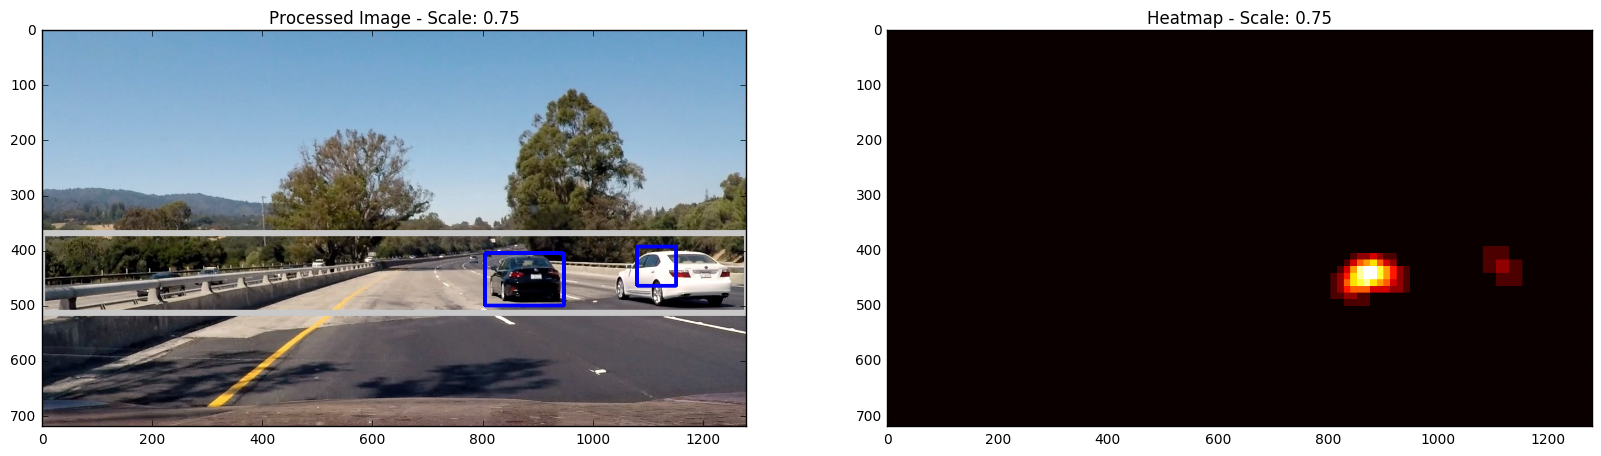

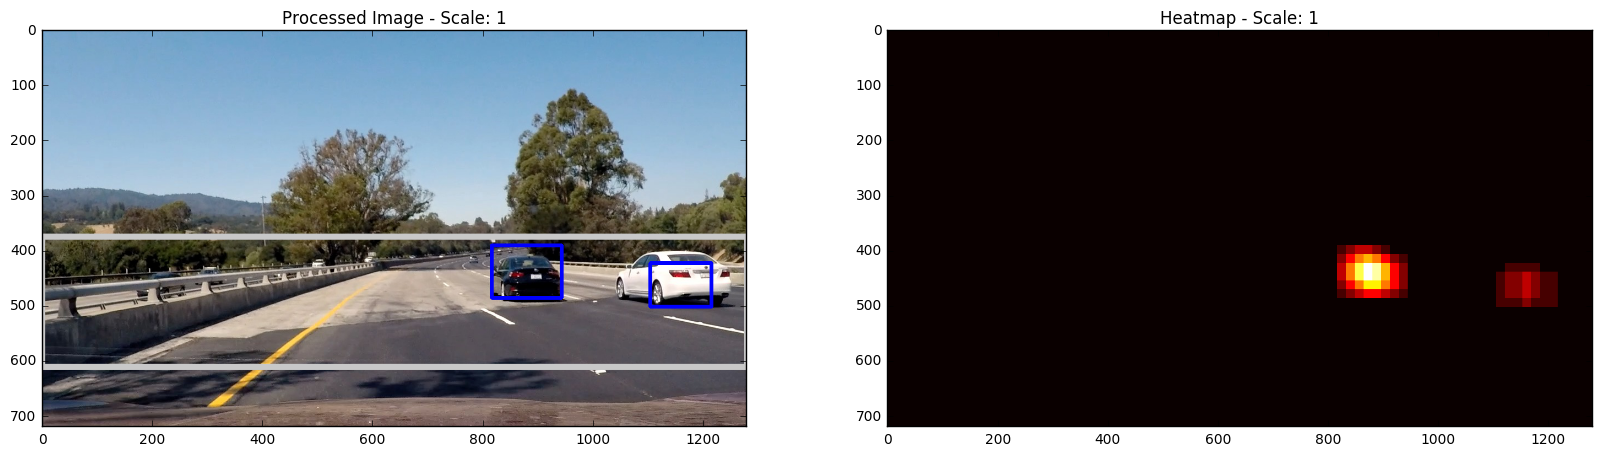

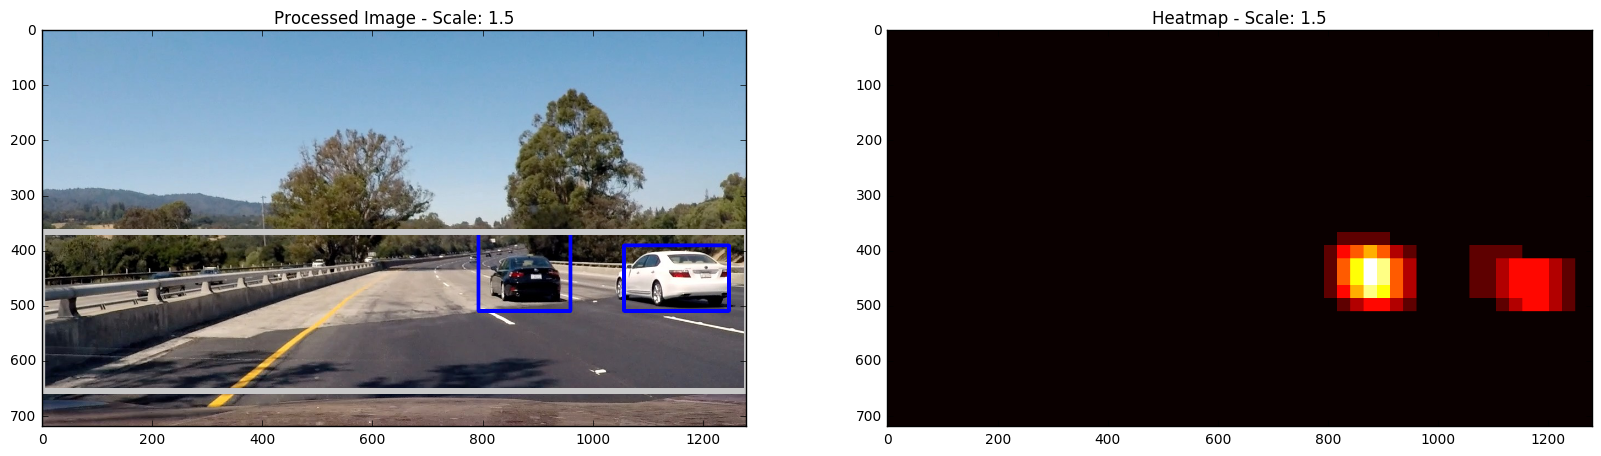

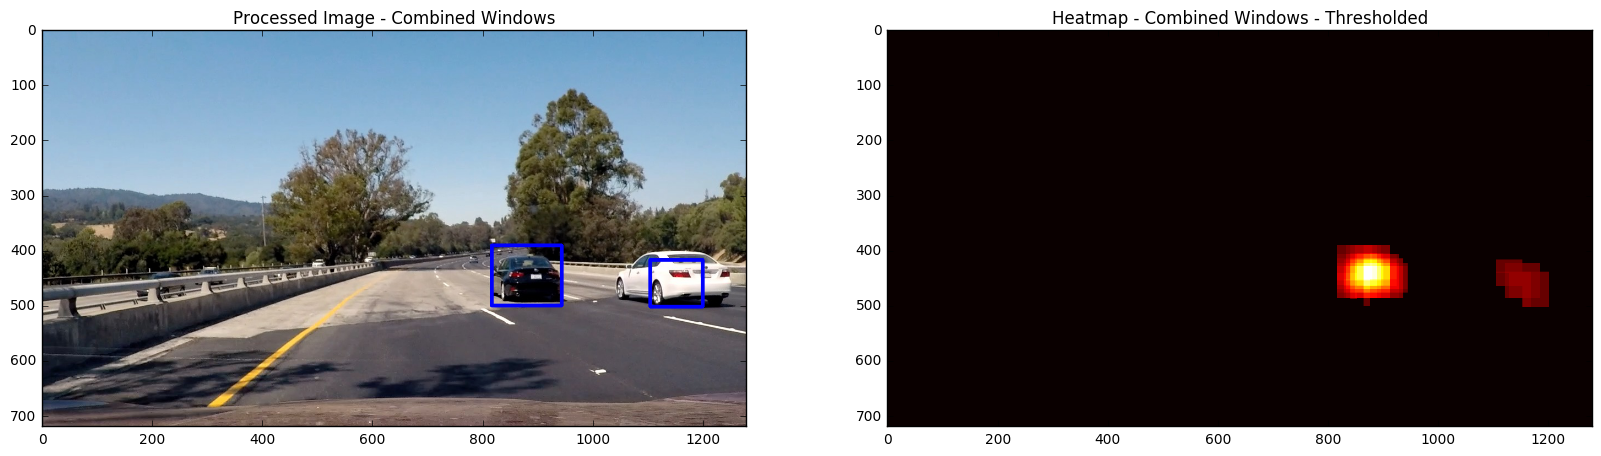

In [105]:
from scipy.ndimage.measurements import label

t = time.time()
image = mpimg.imread('test_images/test4.jpg')
boxes0, heat_map0 = find_cars(image, scale=0.75, conv='RGB2'+color_space, y_start_stop=[370, 514])  # 48x48
boxes1, heat_map1 = find_cars(image, scale=1, conv='RGB2'+color_space, y_start_stop=[376, 612])  # 64x64
boxes2, heat_map2 = find_cars(image, scale=1.5, conv='RGB2'+color_space, y_start_stop=[368, 656])  # 96x96

boxes = boxes0 + boxes1 + boxes2
heat_map = heat_map0 + heat_map1 + heat_map2
heat_map = apply_threshold(heat_map, 3)

# Extract labels
labels0 = label(heat_map0)
labels1 = label(heat_map1)
labels2 = label(heat_map2)
labels =  label(heat_map)

# Draw bounding boxes on a copy of the image
draw_img0 = draw_boxes(np.copy(image), boxes0)
draw_img1 = draw_boxes(np.copy(image), boxes1)
draw_img2 = draw_boxes(np.copy(image), boxes2)
draw_img = draw_boxes(np.copy(image), boxes)

heat_img0 = draw_labeled_bboxes(np.copy(image), labels0)
heat_img1 = draw_labeled_bboxes(np.copy(image), labels1)
heat_img2 = draw_labeled_bboxes(np.copy(image), labels2)
heat_img = draw_labeled_bboxes(np.copy(image), labels)

t2 = time.time()
print(round(t2 - t, 2), 'seconds to predict a single image.')

plt.figure(figsize=(20,10))
plt.subplot(121)
# Plot the detection area -- may be useful:
heat_img0 = cv2.rectangle(heat_img0, (0, 370), (heat_img0.shape[1], 514), (200,200,200), 10)
plt.imshow(heat_img0)
plt.title('Processed Image - Scale: 0.75')
plt.subplot(122)
plt.imshow(heat_map0, cmap='hot')
plt.title('Heatmap - Scale: 0.75')
plt.show()

plt.figure(figsize=(20,10))
plt.subplot(121)
heat_img1 = cv2.rectangle(heat_img1, (0, 376), (heat_img1.shape[1], 612), (200,200,200), 10)
plt.imshow(heat_img1)
plt.title('Processed Image - Scale: 1')
plt.subplot(122)
plt.imshow(heat_map1, cmap='hot')
plt.title('Heatmap - Scale: 1')
plt.show()

plt.figure(figsize=(20,10))
plt.subplot(121)
heat_img2 = cv2.rectangle(heat_img2, (0, 368), (heat_img1.shape[1], 656), (200,200,200), 10)
plt.imshow(heat_img2)
plt.title('Processed Image - Scale: 1.5')
plt.subplot(122)
plt.imshow(heat_map2, cmap='hot')
plt.title('Heatmap - Scale: 1.5')
plt.show()

plt.figure(figsize=(20,10))
plt.subplot(121)
plt.imshow(heat_img)
plt.title('Processed Image - Combined Windows')
plt.subplot(122)
plt.imshow(heat_map, cmap='hot')
plt.title('Heatmap - Combined Windows - Thresholded')
plt.show()

---


### Discussion

#### 1. Briefly discuss any problems / issues you faced in your implementation of this project.  Where will your pipeline likely fail?  What could you do to make it more robust?

This was a hard problem to tackle, as one really frustrating thing was the amount of time it took to test changes in the video pipeline, since each frame took roughly a second to process, so the whole video took around 20 minutes total. The main approach I took was to get each working block out of the lesson material, join them together in a processing pipeline and then try and test individual parts for improvement, such as getting the color histogram features. Overall, I would say this project is more sensitive to changes in color spaces, thresholding and some parameters such as the number of windows and scales to seek for cars on the road. I found that the bounding boxes were not that stable and that even with all the processing it took, there are still a number of false positives.

Another tricky thing is to actually know when the classifier is doing a good or bad job at detecting cars, since a higher testing score would normally be related to a better classification, but during my testing, I found that that was not necessarily the case.